In [1]:
# --------------------------
# Parameterized Train-only Pipeline for Historical Data
# --------------------------
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import joblib
import re

# --------------------------
# === USER-EDITABLE PARAMETERS ===
# --------------------------
CSV_PATH = "eth_coincodex_2015-08-07_2025-09-27.csv"
MODEL_SAVE_PATH = "eth_lstm_sentiment_model1.pth"
SCALER_SAVE_PATH = "eth_scaler1.pkl"

SEQ_LEN = 183
BATCH_SIZE = 16
EPOCHS = 50
LR = 5e-4
WEIGHT_DECAY = 1e-4

HIDDEN_SIZE = 40
NUM_LAYERS = 2
DROPOUT = 0.3

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --------------------------
# Dataset Class
# --------------------------
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# --------------------------
# LSTM Classifier
# --------------------------
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, num_classes=3, dropout=DROPOUT):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                            bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size*2, num_classes)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.dropout(out)
        return self.fc(out)

# --------------------------
# Utility Functions
# --------------------------
def sanitize_filename(name):
    return re.sub(r"[^a-zA-Z0-9_]", "_", name)

def load_historical(csv_path):
    df = pd.read_csv(csv_path)
    df = df.rename(columns={"Start":"timestamp","Open":"open","High":"high","Low":"low",
                            "Close":"close","Volume":"volume","Market Cap":"market_cap"})
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df[["timestamp","open","high","low","close","volume","market_cap"]]
    df = df.dropna(subset=["open","high","low","close","volume"])
    return df.reset_index(drop=True)

def add_features(df):
    df = df.copy()
    df["return"] = df["close"].pct_change()
    df["log_return"] = np.log(df["close"] / df["close"].shift(1))
    df["sma_7"] = df["close"].rolling(7).mean()
    df["sma_30"] = df["close"].rolling(30).mean()
    df["ema_14"] = df["close"].ewm(span=14).mean()
    df["volatility_7"] = df["return"].rolling(7).std()
    df["atr"] = (df["high"] - df["low"]).rolling(14).mean()
    delta = df["close"].diff()
    gain = np.where(delta>0, delta, 0)
    loss = np.where(delta<0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(14).mean()
    avg_loss = pd.Series(loss).rolling(14).mean()
    rs = avg_gain / (avg_loss + 1e-9)
    df["rsi"] = 100 - (100 / (1 + rs))
    ema12 = df["close"].ewm(span=12).mean()
    ema26 = df["close"].ewm(span=26).mean()
    df["macd"] = ema12 - ema26
    df["vol_change"] = df["volume"].pct_change()
    df["obv"] = (np.sign(df["return"]) * df["volume"]).cumsum()
    return df

def generate_next_day_labels(df, threshold=0.01):
    df = df.copy()
    df["return"] = df["close"].shift(-1) / df["close"] - 1
    df["label"] = 1
    df.loc[df["return"] > threshold, "label"] = 2
    df.loc[df["return"] < -threshold, "label"] = 0
    df["label"] = df["label"].fillna(1).astype(int)
    class_ratios = df["label"].value_counts(normalize=True).to_dict()
    return df, class_ratios

def create_sequences(df, features, target_col="label", seq_len=SEQ_LEN):
    sequences, labels = [], []
    data = df[features + [target_col]].values
    for i in range(len(data) - seq_len):
        seq_x = data[i:i+seq_len, :-1]
        seq_y = data[i+seq_len, -1]
        sequences.append(seq_x)
        labels.append(seq_y)
    return np.array(sequences), np.array(labels)

# --------------------------
# Class-weight helper
# --------------------------
def get_class_weights(y_train, num_classes=3, device=DEVICE):
    """
    Compute balanced class weights for classes present in y_train,
    and return a tensor of length `num_classes` with default 1.0
    for any missing classes.
    """
    unique_classes = np.unique(y_train).astype(int)
    # default weights = 1.0 for all classes (including any missing ones)
    weights = np.ones(num_classes, dtype=np.float32)

    # compute weights only for present classes
    computed = compute_class_weight(class_weight="balanced", classes=unique_classes, y=y_train)
    for i, cls in enumerate(unique_classes):
        # cls should be an int label (0,1,2); place computed weight at that index
        weights[int(cls)] = computed[i]

    return torch.tensor(weights, dtype=torch.float32).to(device)

# --------------------------
# Training Function
# --------------------------
def train_model(csv_path=CSV_PATH,
                model_save_path=MODEL_SAVE_PATH,
                scaler_save_path=SCALER_SAVE_PATH,
                seq_len=SEQ_LEN,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                lr=LR,
                hidden_size=HIDDEN_SIZE,
                num_layers=NUM_LAYERS,
                dropout=DROPOUT,
                weight_decay=WEIGHT_DECAY):

    # Load & preprocess
    df = load_historical(csv_path)
    df = add_features(df)
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    df, ratios = generate_next_day_labels(df)
    print("Class ratios in training data:", ratios)

    features = [c for c in df.columns if c not in ["timestamp","label","return"]]
    

    # Safety check: shrink seq_len if dataset is too short
    if len(df) <= seq_len:
        old_seq_len = seq_len
        seq_len = max(2, len(df) - 1)  # at least 2 rows
        print(f"⚠️ SEQ_LEN={old_seq_len} too large for dataset with {len(df)} rows. Using SEQ_LEN={seq_len} instead.")

    X, y = create_sequences(df, features, seq_len=seq_len)
    if len(X) == 0:
        raise ValueError(f"Not enough data for SEQ_LEN={seq_len}")

    # Train/Val split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

    # --------------------------
    # Fit scaler only on training data
    # --------------------------
    n_train, t, f = X_train.shape
    n_val = X_val.shape[0]

    # Flatten sequences
    X_train_2d = X_train.reshape(-1, f)
    X_val_2d   = X_val.reshape(-1, f)

    # Fit scaler with feature names
    scaler = StandardScaler()
    X_train = scaler.fit_transform(pd.DataFrame(X_train_2d, columns=features)).reshape(n_train, t, f)
    X_val   = scaler.transform(pd.DataFrame(X_val_2d, columns=features)).reshape(n_val, t, f)

    joblib.dump(scaler, scaler_save_path)

    # Wrap in datasets/loaders
    train_loader = DataLoader(TimeSeriesDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TimeSeriesDataset(X_val, y_val), batch_size=batch_size, shuffle=False)

    input_size = X.shape[2]
    model = LSTMClassifier(input_size, hidden_size, num_layers, dropout=dropout)
    model.to(DEVICE)

    # Class weights
    class_weights = get_class_weights(y_train, num_classes=3, device=DEVICE)
    print("Class weights:", class_weights)

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )

    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        # Adjust LR
        scheduler.step(val_loss)

        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Save both model config + state_dict together
    torch.save({
        "model_state": model.state_dict(),
        "input_size": input_size,
        "hidden_size": hidden_size,
        "num_layers": num_layers,
        "dropout": dropout,
        "features": features,
    }, model_save_path)

    print(f"✅ Model (with config) saved to {model_save_path}")
    joblib.dump(scaler, scaler_save_path)
    print(f"✅ Scaler saved to {scaler_save_path}")
    return model, scaler, features

# --------------------------
# Run Training
# --------------------------
model, scaler, features = train_model()


Class ratios in training data: {0: 0.37387755102040815, 2: 0.35374149659863946, 1: 0.2723809523809524}
Class weights: tensor([0.9004, 1.1711, 0.9658], device='cuda:0')
Epoch 5/50, Train Loss: 1.0292, Val Loss: 1.0426, LR: 0.000500
Epoch 10/50, Train Loss: 1.0191, Val Loss: 1.0514, LR: 0.000250
Epoch 15/50, Train Loss: 1.0086, Val Loss: 1.0522, LR: 0.000250
Epoch 20/50, Train Loss: 1.0032, Val Loss: 1.0545, LR: 0.000125
Epoch 25/50, Train Loss: 0.9997, Val Loss: 1.0474, LR: 0.000063
Epoch 30/50, Train Loss: 0.9950, Val Loss: 1.0464, LR: 0.000031
Epoch 35/50, Train Loss: 0.9973, Val Loss: 1.0493, LR: 0.000016
Epoch 40/50, Train Loss: 0.9963, Val Loss: 1.0482, LR: 0.000008
Epoch 45/50, Train Loss: 0.9924, Val Loss: 1.0482, LR: 0.000008
Epoch 50/50, Train Loss: 0.9910, Val Loss: 1.0484, LR: 0.000004
✅ Model (with config) saved to eth_lstm_sentiment_model1.pth
✅ Scaler saved to eth_scaler1.pkl


In [2]:
# Predict the next day in the dataset (without Polygon.io)

def load_trained_model(model_path, scaler_path):
    # Load checkpoint (model config + state)
    checkpoint = torch.load(model_path, map_location=DEVICE)

    # Rebuild model with saved config
    model = LSTMClassifier(
        input_size=checkpoint["input_size"],
        hidden_size=checkpoint["hidden_size"],
        num_layers=checkpoint["num_layers"],
        dropout=checkpoint["dropout"],
    )
    model.load_state_dict(checkpoint["model_state"])
    model.to(DEVICE)
    model.eval()

    # Load scaler and features
    scaler = joblib.load(scaler_path)
    features = checkpoint["features"]

    return model, scaler, features


def predict_next_day(df, model, scaler, features, seq_len=SEQ_LEN):
    # Recreate features
    df = add_features(df)
    df = df.replace([np.inf, -np.inf], np.nan).dropna()

    # Ensure all training features exist
    missing = [f for f in features if f not in df.columns]
    if missing:
        raise ValueError(f"❌ Missing features in input data: {missing}")

    # Reorder columns to match training
    df = df[features]

    # Scale features
    df[features] = scaler.transform(df[features])

    # Get the last seq_len rows as input
    if len(df) < seq_len:
        raise ValueError("❌ Not enough data for a prediction")

    X_latest = df[features].values[-seq_len:]
    X_latest = torch.tensor(X_latest, dtype=torch.float32).unsqueeze(0).to(DEVICE)

    # Run model
    with torch.no_grad():
        logits = model(X_latest)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
        pred_class = int(np.argmax(probs))

    return pred_class, probs

# --------------------------
# Usage
# --------------------------
model, scaler, features = load_trained_model(
    model_path="eth_lstm_sentiment_model1.pth",
    scaler_path="eth_scaler1.pkl"
)

df_new = load_historical("eth_coincodex_2015-08-07_2025-09-28.csv")

pred_class, probs = predict_next_day(df_new, model, scaler, features)

mapping = {0: "Bearish", 1: "Neutral", 2: "Bullish"}

# Format confidences as percentages with 3 decimals
probs_percent = [f"{p:.3f}" for p in probs]

print(f"Prediction: {mapping[pred_class]}")
print(f"Confidences -> Bearish: {probs_percent[0]}, Neutral: {probs_percent[1]}, Bullish: {probs_percent[2]}")


Prediction: Neutral
Confidences -> Bearish: 0.264, Neutral: 0.482, Bullish: 0.254


In [3]:
import pandas as pd
from datetime import date, timedelta
from polygon import RESTClient

# -----------------------------
# Polygon.io setup
# -----------------------------
client = RESTClient(api_key="peeXEfM2xJR2calDdtBPMB3RW3dp7KKA")

# Historical CSV
historical_csv_path = "eth_coincodex_2015-08-07_2025-09-27.csv"
historical_df = pd.read_csv(historical_csv_path)

# Ensure Start and End are dates only
historical_df["Start"] = pd.to_datetime(historical_df["Start"]).dt.date
historical_df["End"] = pd.to_datetime(historical_df["End"]).dt.date

# Add Source column
historical_df.insert(0, "Source", "Coincodex")

# -----------------------------
# Determine start date for new fetch
# -----------------------------
last_date = historical_df["End"].max()
start_date = last_date  # start from last End date
end_date = date.today()

if start_date >= end_date:
    print("✅ Historical data is already up to date!")
else:
    print(f"Fetching data from {start_date} to {end_date}...")

    tickers = ["X:ETHUSD"]
    all_data = []

    for ticker in tickers:
        try:
            for a in client.list_aggs(
                ticker,
                1,               # 1-day bars
                "day",
                start_date.isoformat(),
                end_date.isoformat(),
                limit=5000
            ):
                # Polygon timestamp +1 day to match historical End convention
                bar_date = (pd.to_datetime(a.timestamp, unit="ms") + timedelta(days=1)).date()
                all_data.append({
                    "ticker": ticker,
                    "timestamp": bar_date,
                    "open": a.open,
                    "high": a.high,
                    "low": a.low,
                    "close": a.close,
                    "volume": a.volume
                })
        except Exception as e:
            print(f"⚠️ Error fetching {ticker}: {e}")

    if all_data:
        new_df = pd.DataFrame(all_data)

        # -----------------------------
        # Align columns with historical CSV
        # -----------------------------
        new_df.rename(columns={
            "timestamp": "End",
            "open": "Open",
            "high": "High",
            "low": "Low",
            "close": "Close",
            "volume": "Volume"
        }, inplace=True)

        # Start = End - 1 day
        new_df["Start"] = new_df["End"] - pd.to_timedelta(1, unit="d")

        # Placeholder Market Cap
        new_df["Market Cap"] = new_df["Close"] * new_df["Volume"]

        # Add Source column
        new_df.insert(0, "Source", "Polygon")

        # Keep columns in correct order
        new_df = new_df[["Source", "Start", "End", "Open", "High", "Low", "Close", "Volume", "Market Cap"]]

        # -----------------------------
        # Merge with historical
        # -----------------------------
        combined_df = pd.concat([historical_df, new_df], ignore_index=True)
        combined_df = combined_df.drop_duplicates(subset=["End"], keep="last")
        combined_df = combined_df.sort_values("End").reset_index(drop=True)

        # Save updated CSV
        combined_csv_path = "eth_combined_updated.csv"
        combined_df.to_csv(combined_csv_path, index=False)
        print(f"✅ Combined data saved to {combined_csv_path}")
    else:
        print("⚠️ No new data fetched from Polygon. Historical CSV is up to date!")


Fetching data from 2025-09-28 to 2025-10-03...
✅ Combined data saved to eth_combined_updated.csv


In [4]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import numpy as np

# -----------------------------
# Load combined data
# -----------------------------
df_all = pd.read_csv("eth_combined_updated.csv")

# Rename columns to match feature function
df_all.rename(columns={
    "Open": "open",
    "High": "high",
    "Low": "low",
    "Close": "close",
    "Volume": "volume",
    "Market Cap": "market_cap",
    "Start": "start",
    "End": "end",
    "Source": "source"
}, inplace=True)
df_all = df_all.reset_index(drop=True)

# -----------------------------
# Add features exactly as in training
# -----------------------------
df_all = add_features(df_all)
df_all = df_all.replace([np.inf, -np.inf], pd.NA).dropna()
df_all = generate_next_day_labels(df_all)[0]  # adds 'label'

# -----------------------------
# Load model, scaler, features
# -----------------------------
def load_trained_model(model_path, scaler_path):
    checkpoint = torch.load(model_path, map_location=DEVICE)
    model = LSTMClassifier(
        input_size=checkpoint["input_size"],
        hidden_size=checkpoint["hidden_size"],
        num_layers=checkpoint["num_layers"],
        dropout=checkpoint["dropout"],
    )
    model.load_state_dict(checkpoint["model_state"])
    model.to(DEVICE)
    model.eval()
    scaler = joblib.load(scaler_path)
    features = checkpoint["features"]
    return model, scaler, features

model, scaler, features = load_trained_model(
    "eth_lstm_sentiment_model1.pth",
    "eth_scaler1.pkl"
)

# -----------------------------
# Build evaluation sequences
# -----------------------------
SEQ_LEN_eval = SEQ_LEN
X_eval_list, y_eval_list = [], []

# Polygon indices
polygon_idx = df_all.index[df_all["source"] == "Polygon"].tolist()
if not polygon_idx:
    raise ValueError("No Polygon rows found")

for idx in polygon_idx:
    if idx - SEQ_LEN_eval + 1 < 0:
        continue
    seq_window = df_all.loc[idx - SEQ_LEN_eval + 1: idx]
    X_seq = seq_window[features].values
    y_seq = seq_window["label"].values[-1]
    X_eval_list.append(X_seq)
    y_eval_list.append(y_seq)

if len(X_eval_list) == 0:
    raise ValueError("Not enough sequences for evaluation")

X_eval = torch.tensor(np.array(X_eval_list), dtype=torch.float32)
y_eval = torch.tensor(np.array(y_eval_list), dtype=torch.long)

# -----------------------------
# Scale sequences
# -----------------------------
n_eval, t, f = X_eval.shape
X_eval_2d = X_eval.reshape(-1, f)
X_eval_scaled = torch.tensor(
    scaler.transform(pd.DataFrame(X_eval_2d, columns=features)).reshape(n_eval, t, f),
    dtype=torch.float32
)

# -----------------------------
# Build DataLoader
# -----------------------------
eval_loader = DataLoader(
    list(zip(X_eval_scaled, y_eval)),
    batch_size=16,
    shuffle=False
)

# -----------------------------
# Evaluate
# -----------------------------
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for X_batch, y_batch in eval_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
        logits = model(X_batch)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

print(f"✅ Accuracy: {accuracy_score(all_labels, all_preds):.4f}\n")
print(classification_report(all_labels, all_preds, target_names=["Bearish","Neutral","Bullish"]))
print(confusion_matrix(all_labels, all_preds))


✅ Accuracy: 0.3333

              precision    recall  f1-score   support

     Bearish       0.00      0.00      0.00         1
     Neutral       0.00      0.00      0.00         2
     Bullish       0.40      0.67      0.50         3

    accuracy                           0.33         6
   macro avg       0.13      0.22      0.17         6
weighted avg       0.20      0.33      0.25         6

[[0 0 1]
 [0 0 2]
 [0 1 2]]


d:\Python3.11.7\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Python3.11.7\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Python3.11.7\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [5]:
# --------------------------
# Retrain on recent data
# --------------------------
model, scaler, features = train_model(
    csv_path="eth_combined_updated.csv",
    model_save_path="eth_lstm_sentiment_model2.pth",
    scaler_save_path="eth_scaler2.pkl"
)


Class ratios in training data: {2: 0.3740831295843521, 0: 0.34990491714208094, 1: 0.276011953273567}
Class weights: tensor([0.9478, 1.2272, 0.8849], device='cuda:0')
Epoch 5/50, Train Loss: 1.0708, Val Loss: 1.1137, LR: 0.000500
Epoch 10/50, Train Loss: 1.0618, Val Loss: 1.1171, LR: 0.000250
Epoch 15/50, Train Loss: 1.0572, Val Loss: 1.1234, LR: 0.000125
Epoch 20/50, Train Loss: 1.0550, Val Loss: 1.1220, LR: 0.000063
Epoch 25/50, Train Loss: 1.0538, Val Loss: 1.1199, LR: 0.000031
Epoch 30/50, Train Loss: 1.0510, Val Loss: 1.1218, LR: 0.000031
Epoch 35/50, Train Loss: 1.0508, Val Loss: 1.1220, LR: 0.000016
Epoch 40/50, Train Loss: 1.0516, Val Loss: 1.1220, LR: 0.000008
Epoch 45/50, Train Loss: 1.0504, Val Loss: 1.1223, LR: 0.000004
Epoch 50/50, Train Loss: 1.0517, Val Loss: 1.1223, LR: 0.000002
✅ Model (with config) saved to eth_lstm_sentiment_model2.pth
✅ Scaler saved to eth_scaler2.pkl


In [8]:
# --------------------------
# Next Day prediction after combined training
# --------------------------
model, scaler, features = load_trained_model(
    model_path="eth_lstm_sentiment_model2.pth",
    scaler_path="eth_scaler2.pkl"
)

df_new = load_historical("eth_coincodex_2015-08-07_2025-09-27.csv")

pred_class, probs = predict_next_day(df_new, model, scaler, features)

mapping = {0: "Bearish", 1: "Neutral", 2: "Bullish"}

probs_percent = [f"{p:.3f}" for p in probs]

print(f"Prediction: {mapping[pred_class]}")
print(f"Confidences -> Bearish: {probs_percent[0]}, Neutral: {probs_percent[1]}, Bullish: {probs_percent[2]}")


Prediction: Bearish
Confidences -> Bearish: 0.535, Neutral: 0.107, Bullish: 0.358


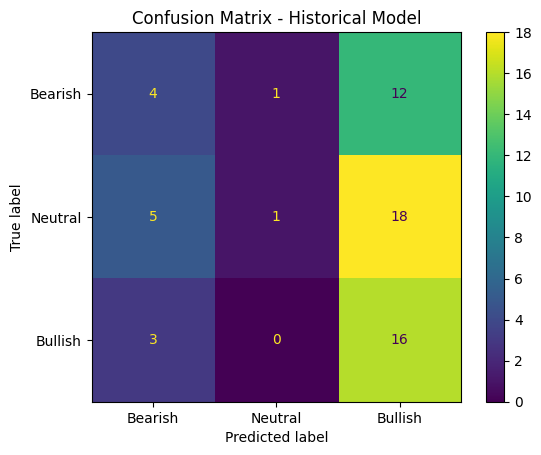

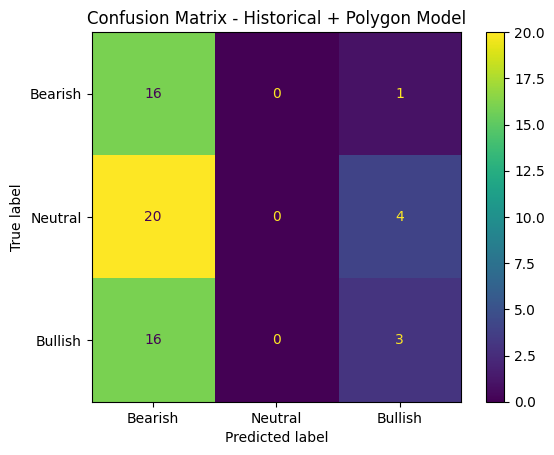

Historical Model:
              precision    recall  f1-score   support

     Bearish       0.33      0.24      0.28        17
     Neutral       0.50      0.04      0.08        24
     Bullish       0.35      0.84      0.49        19

    accuracy                           0.35        60
   macro avg       0.39      0.37      0.28        60
weighted avg       0.40      0.35      0.26        60

Historical + Polygon Model:
              precision    recall  f1-score   support

     Bearish       0.31      0.94      0.46        17
     Neutral       0.00      0.00      0.00        24
     Bullish       0.38      0.16      0.22        19

    accuracy                           0.32        60
   macro avg       0.23      0.37      0.23        60
weighted avg       0.21      0.32      0.20        60



d:\Python3.11.7\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Python3.11.7\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Python3.11.7\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [11]:
model1, scaler1, features = load_trained_model(
    model_path="eth_lstm_sentiment_model1.pth",
    scaler_path="eth_scaler1.pkl"
)

model2, scaler2, features = load_trained_model(
    model_path="eth_lstm_sentiment_model2.pth",
    scaler_path="eth_scaler2.pkl"
)

import torch
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# -----------------------------
# Load test CSV
# -----------------------------
df_test = pd.read_csv("eth_combined_updated.csv")
df_test["End"] = pd.to_datetime(df_test["End"])

# Rename columns to lowercase as expected by feature functions
df_test.rename(columns={
    "Open": "open",
    "High": "high",
    "Low": "low",
    "Close": "close",
    "Volume": "volume",
    "Market Cap": "market_cap",
    "Start": "start",
    "End": "end",
    "Source": "source"
}, inplace=True)

# -----------------------------
# Feature engineering & labels
# -----------------------------
df_test = add_features(df_test)
df_test = df_test.replace([np.inf, -np.inf], np.nan).dropna()
df_test = generate_next_day_labels(df_test)[0]

# -----------------------------
# Select last test window
# -----------------------------
test_window = 60
df_test_window = df_test.iloc[-(test_window + SEQ_LEN):]  # include SEQ_LEN for sequences
X_test, y_test = create_sequences(df_test_window, features)  # shape: list/array [num_seq, SEQ_LEN, num_features]

# -----------------------------
# Scale sequences properly
# -----------------------------
def scale_sequences(X, scaler, feature_names):
    num_seq, seq_len, num_feat = X.shape
    X_flat = X.reshape(-1, num_feat)  # flatten to 2D
    # wrap in DataFrame with original feature names
    X_df = pd.DataFrame(X_flat, columns=feature_names)
    X_scaled_flat = scaler.transform(X_df)
    X_scaled = X_scaled_flat.reshape(num_seq, seq_len, num_feat)
    return X_scaled

X_test_scaled1 = scale_sequences(X_test, scaler1, features)
X_test_scaled2 = scale_sequences(X_test, scaler2, features)

# -----------------------------
# Predict function
# -----------------------------
def predict_model(model, X):
    model.eval()
    X_tensor = torch.tensor(X, dtype=torch.float32).to(DEVICE)
    with torch.no_grad():
        logits = model(X_tensor)
        preds = torch.argmax(torch.softmax(logits, dim=1), dim=1).cpu().numpy()
    return preds

y_pred1 = predict_model(model1, X_test_scaled1)
y_pred2 = predict_model(model2, X_test_scaled2)

# -----------------------------
# Confusion Matrices
# -----------------------------
labels = ["Bearish", "Neutral", "Bullish"]

cm1 = confusion_matrix(y_test, y_pred1)
disp1 = ConfusionMatrixDisplay(cm1, display_labels=labels)
disp1.plot()
plt.title("Confusion Matrix - Historical Model")
plt.show()

cm2 = confusion_matrix(y_test, y_pred2)
disp2 = ConfusionMatrixDisplay(cm2, display_labels=labels)
disp2.plot()
plt.title("Confusion Matrix - Historical + Polygon Model")
plt.show()

# -----------------------------
# Classification Reports
# -----------------------------
print("Historical Model:")
print(classification_report(y_test, y_pred1, target_names=labels))

print("Historical + Polygon Model:")
print(classification_report(y_test, y_pred2, target_names=labels))



In [12]:
# Number of rows used in test sequences
print("Total test rows selected (including SEQ_LEN):", len(df_test_window))

# Check last few rows
print(df_test_window.tail(10))

# Check label distribution in test window
print("Label counts in test window:")
print(df_test_window['label'].value_counts())

# Optionally, show the ratio of classes in the test window
label_ratios = df_test_window['label'].value_counts(normalize=True).to_dict()
print("Label ratios in test window:", label_ratios)


Total test rows selected (including SEQ_LEN): 243
         source       start        end       open       high        low  \
3700  Coincodex  2025-09-24 2025-09-25  4166.9268  4202.1611  4103.0666   
3701  Coincodex  2025-09-25 2025-09-26  4157.3862  4160.1025  3832.1807   
3702  Coincodex  2025-09-26 2025-09-27  3887.7951  4064.4365  3880.2124   
3703  Coincodex  2025-09-27 2025-09-28  4030.8095  4032.4239  3978.5980   
3704    Polygon  2025-09-28 2025-09-29  4019.6400  4154.3000  3965.7800   
3705    Polygon  2025-09-29 2025-09-30  4143.3600  4250.0000  4084.0000   
3706    Polygon  2025-09-30 2025-10-01  4218.0100  4256.5000  4093.0000   
3707    Polygon  2025-10-01 2025-10-02  4145.9800  4359.7200  4123.3500   
3708    Polygon  2025-10-02 2025-10-03  4350.5200  4530.8500  4335.0100   
3709    Polygon  2025-10-03 2025-10-04  4487.3000  4596.1900  4430.0800   

          close        volume    market_cap    return  ...        sma_7  \
3700  4149.7638  4.558630e+10  5.034755e+11 -0.06